In [1]:
import scanpy as sc
adata = sc.datasets.pbmc3k()

100%|██████████| 5.58M/5.58M [00:02<00:00, 2.09MB/s]


In [2]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.decomposition import PCA
import ot

import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

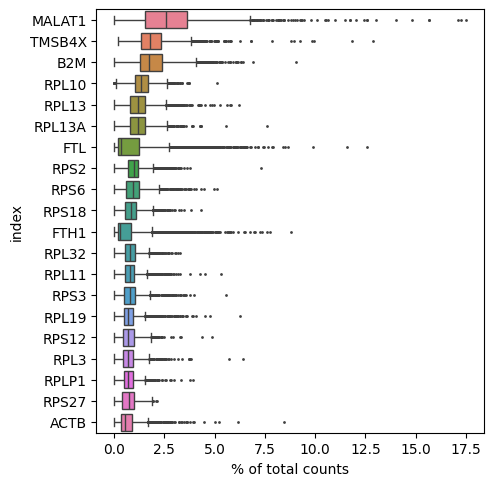

In [4]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [5]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [6]:
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

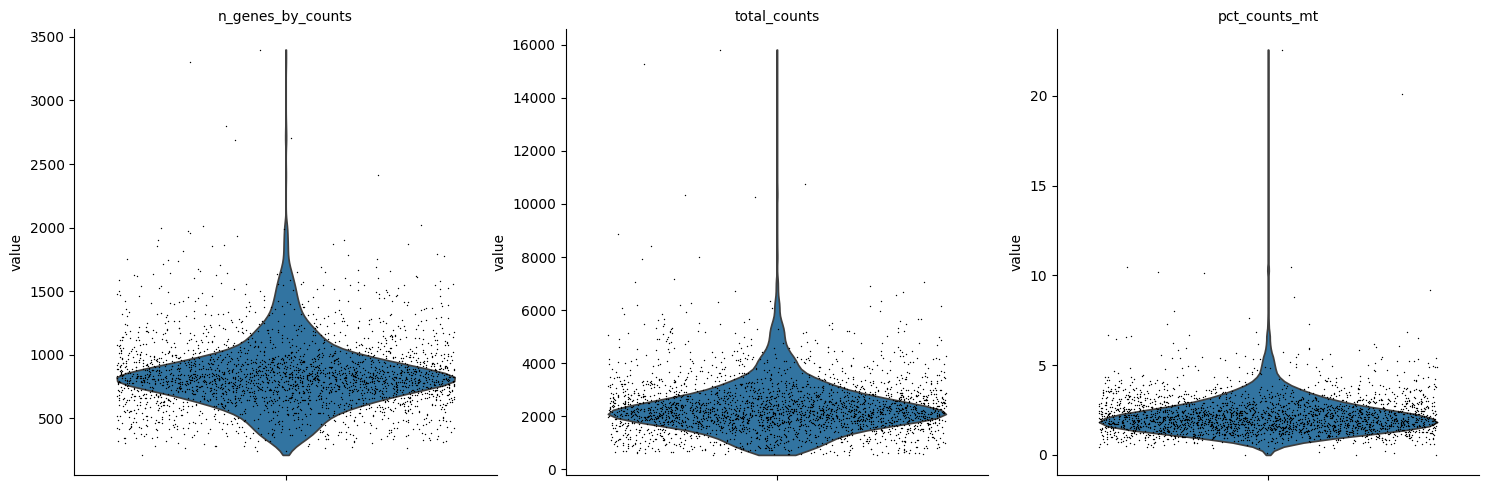

In [7]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [8]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

In [9]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [10]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


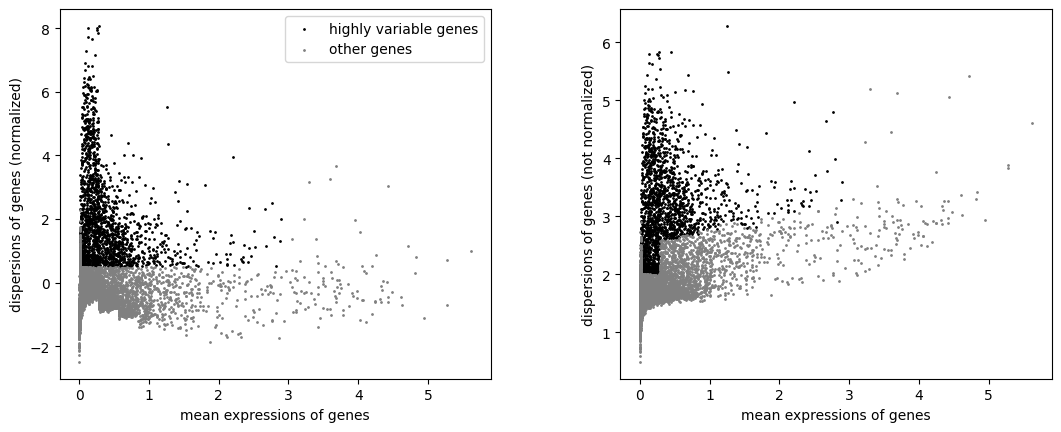

In [11]:
sc.pl.highly_variable_genes(adata)

In [12]:
adata.raw = adata

In [13]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

In [14]:
sc.pp.scale(adata, max_value=10)

In [15]:
sc.tl.pca(adata, svd_solver="arpack")

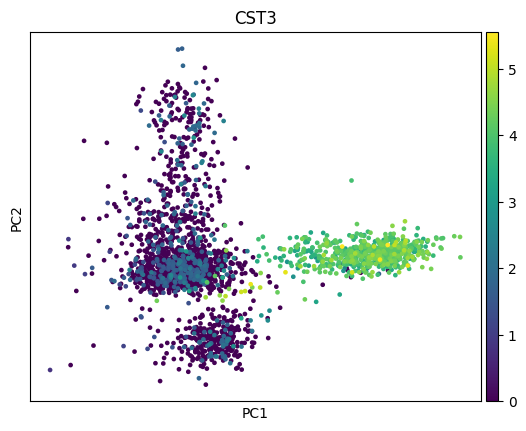

In [16]:
sc.pl.pca(adata, color="CST3")

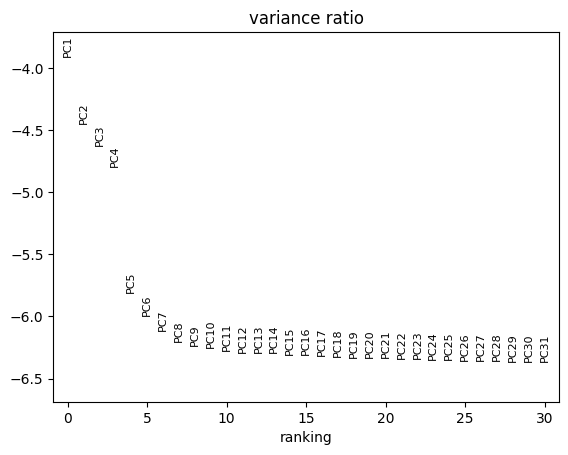

In [17]:
sc.pl.pca_variance_ratio(adata, log=True)

In [18]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [20]:
sc.tl.umap(adata)

In [21]:
sc.tl.leiden(
    adata,
    resolution=0.9,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)

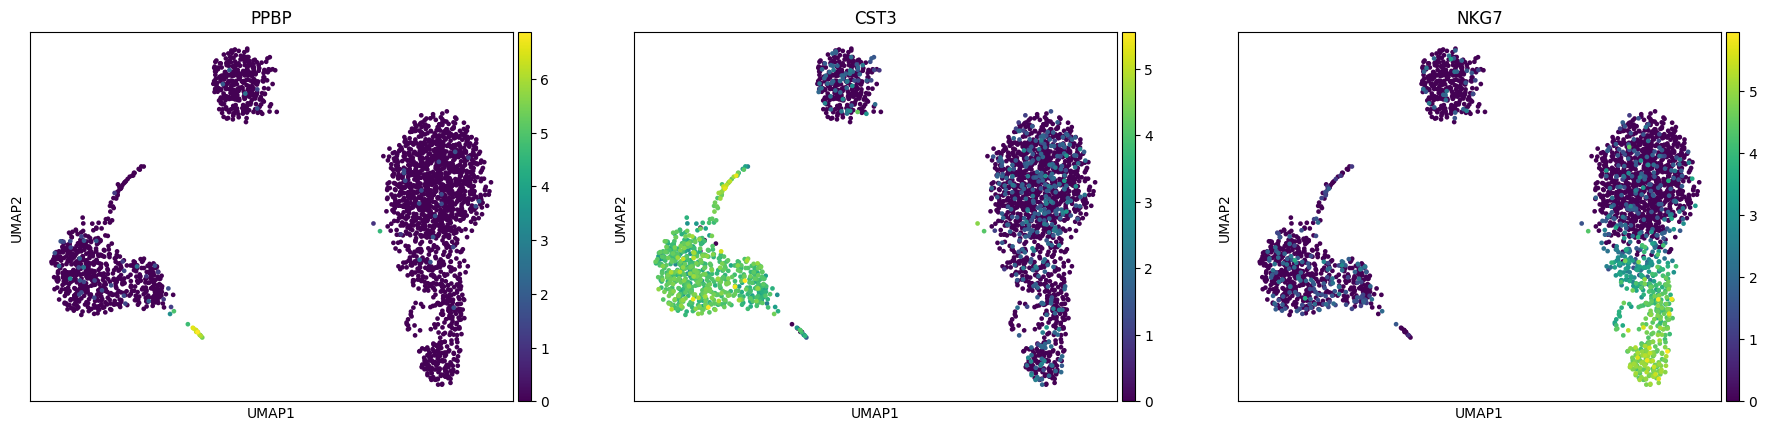

In [22]:
sc.pl.umap(adata, color=["PPBP", "CST3", "NKG7"])

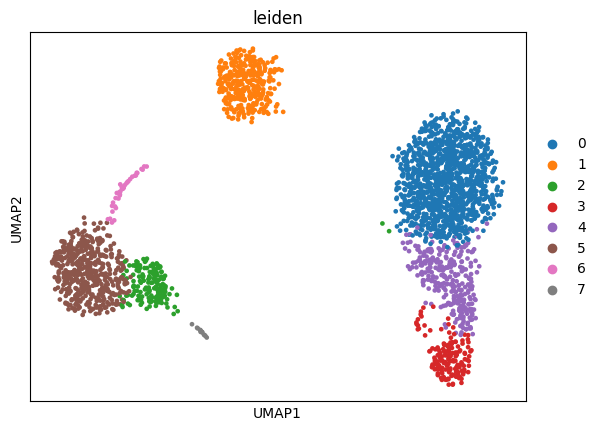

In [23]:
sc.pl.umap(adata, color=["leiden"])

In [24]:
marker_genes = [
    *["IL7R", "CD79A", "MS4A1", "CD8A", "CD8B", "LYZ", "CD14"],
    *["LGALS3", "S100A8", "GNLY", "NKG7", "KLRB1"],
    *["FCGR3A", "MS4A7", "FCER1A", "CST3", "PPBP"],
]

In [25]:
new_cluster_names = [
    "CD4 T",
    "B",
    "FCGR3A+ Monocytes",
    "NK",
    "CD8 T",
    "CD14+ Monocytes",
    "Dendritic",
    "Megakaryocytes",
]
adata.rename_categories("leiden", new_cluster_names)

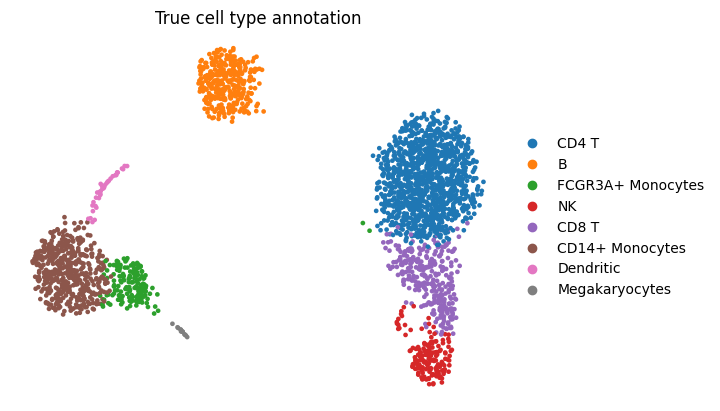

In [26]:
sc.pl.umap(
    adata, color="leiden", title="True cell type annotation", frameon=False
)

In [27]:
marker_genes_dict = {
    'B cells predicted': ['CD19', 'MS4A1'],
    'CD4 T cells predicted': ['LDHB', 'IL7R'],
    'CD14+ Monocytes predicted': ['LYZ', 'S100A9', 'S100A8'],
    'CD8 T cells predicted': ['CD8A'],
    'NK cells predicted': ['GNLY', 'NKG7', 'GZMB'],
    'FCGR3A+ Monocytes predicted': ['FCGR3A', 'MS4A7'],
    'Dendritic Cells predicted': ['FCER1A', 'HLA-DRA', 'HLA-DQA1'],
    'Megakaryocytes predicted': ['PPBP']
    # Add more cell types and their marker genes as needed
}


In [28]:
# Verify that marker genes are present in your dataset
for cell_type, genes in marker_genes_dict.items():
    genes_present = [gene for gene in genes if gene in adata.var_names]
    if len(genes_present) == 0:
        print(f"No marker genes found for {cell_type}. Please check gene names.")
    else:
        marker_genes_dict[cell_type] = genes_present

In [30]:
def perform_annotation_analysis(marker_genes, adata, target_cluster, n_pc, num_permutations=1000, lambda_reg=10):
    """
    Perform OT Sinkhorn distance calculation and permutation test for a given set of marker genes.

    Parameters:
    - marker_genes: list of gene names to use for the analysis
    - adata: AnnData object containing your single-cell data
    - target_cluster: the cluster label (from 'louvain') to define group0
    - num_permutations: number of permutations for the permutation test
    - lambda_reg: regularization parameter for Sinkhorn

    Returns:
    - observed_distance: Observed OT Sinkhorn distance
    - p_value: p-value from the permutation test
    """
    # Set random seed for reproducibility
    np.random.seed(666)
    
    # Step 1: Define Group0 and Group1 based on target_cluster
    group0 = adata[adata.obs['leiden'] == target_cluster]
    group1 = adata[adata.obs['leiden'] != target_cluster]

    # Check if both groups have enough cells
    if group0.n_obs == 0 or group1.n_obs == 0:
        print(f"Insufficient cells in group0 or group1 for cluster {target_cluster}.")
        return np.nan, np.nan

    # Step 2: Extract gene expression data for the marker genes
    group0_marker = group0[:, marker_genes]
    group1_marker = group1[:, marker_genes]

    # Verify that marker genes are present
    if group0_marker.shape[1] == 0 or group1_marker.shape[1] == 0:
        print(f"No marker genes found for the provided list in cluster {target_cluster}. Skipping.")
        return np.nan, np.nan

    # Step 3: Convert to DataFrame for easier manipulation
    df_expression_group0 = pd.DataFrame(group0_marker.X.toarray(), columns=group0_marker.var_names)
    df_expression_group1 = pd.DataFrame(group1_marker.X.toarray(), columns=group1_marker.var_names)

    # Step 4: Perform PCA for dimensionality reduction
    pca = PCA(n_components=n_pc)
    group0_pcs = pca.fit_transform(df_expression_group0)
    group1_pcs = pca.fit_transform(df_expression_group1)  # Use transform to maintain PCA space

    # Step 5: Fit KDE for both groups in PCA space
    try:
        kde_group0 = stats.gaussian_kde(group0_pcs.T, bw_method='scott')
        kde_group1 = stats.gaussian_kde(group1_pcs.T, bw_method='scott')
    except np.linalg.LinAlgError:
        print(f"KDE failed for cluster {target_cluster}. Possibly due to singular data.")
        return np.nan, np.nan

    # Evaluate densities
    density_group0 = kde_group0(group0_pcs.T)
    density_group1 = kde_group1(group1_pcs.T)

    # Step 6: Normalize densities to create probability distributions
    mu = (density_group0 - density_group0.min()) / (density_group0.max() - density_group0.min())
    nu = (density_group1 - density_group1.min()) / (density_group1.max() - density_group1.min())

    # Step 7: Compute the cost matrix between cells in the two groups
    X_group0 = df_expression_group0.values
    X_group1 = df_expression_group1.values
    cost_matrix = ot.dist(X_group0, X_group1, metric='euclidean')
    cost_matrix_norm = (cost_matrix - cost_matrix.min()) / (cost_matrix.max() - cost_matrix.min())

    # Step 8: Compute the OT Sinkhorn plan and distance
    transport_plan = ot.sinkhorn(mu, nu, cost_matrix_norm, lambda_reg)
    observed_distance = np.sum(transport_plan * cost_matrix_norm)

    # Step 9: Permutation Test
    combined_X = np.vstack([X_group0, X_group1])
    n_group0 = X_group0.shape[0]
    n_group1 = X_group1.shape[0]
    permuted_distances = []

    for i in range(num_permutations):
        # Shuffle the combined data
        permuted_indices = np.random.permutation(combined_X.shape[0])
        perm_group0 = combined_X[permuted_indices[:n_group0], :]
        perm_group1 = combined_X[permuted_indices[n_group0:], :]

        # Perform PCA on permuted groups using the original PCA model
        try:
            perm_group0_pcs = pca.transform(perm_group0)
            perm_group1_pcs = pca.transform(perm_group1)
        except ValueError:
            # In case the permutation results in invalid data for PCA
            permuted_distances.append(np.nan)
            continue

        # Fit KDE for permuted groups
        try:
            kde_perm_group0 = stats.gaussian_kde(perm_group0_pcs.T, bw_method='scott')
            kde_perm_group1 = stats.gaussian_kde(perm_group1_pcs.T, bw_method='scott')
            # Evaluate densities
            density_perm_group0 = kde_perm_group0(perm_group0_pcs.T)
            density_perm_group1 = kde_perm_group1(perm_group1_pcs.T)
        except np.linalg.LinAlgError:
            # In case KDE fails due to singular data
            permuted_distances.append(np.nan)
            continue

        # Normalize densities
        mu_perm = (density_perm_group0 - density_perm_group0.min()) / (density_perm_group0.max() - density_perm_group0.min())
        nu_perm = (density_perm_group1 - density_perm_group1.min()) / (density_perm_group1.max() - density_perm_group1.min())

        # Compute cost matrix for permuted groups
        cost_matrix_perm = ot.dist(perm_group0, perm_group1, metric='euclidean')
        cost_matrix_perm_norm = (cost_matrix_perm - cost_matrix_perm.min()) / (cost_matrix_perm.max() - cost_matrix_perm.min())

        # Compute OT Sinkhorn distance for permuted data
        transport_plan_perm = ot.sinkhorn(mu_perm, nu_perm, cost_matrix_perm_norm, lambda_reg)
        ot_distance_perm = np.sum(transport_plan_perm * cost_matrix_perm_norm)
        permuted_distances.append(ot_distance_perm)

    # Remove NaN values resulting from failed permutations
    permuted_distances = np.array(permuted_distances)
    permuted_distances = permuted_distances[~np.isnan(permuted_distances)]

    # Calculate p-value
    if len(permuted_distances) == 0:
        p_value = np.nan
    else:
        p_value = np.mean(permuted_distances >= observed_distance)

    return observed_distance, p_value

In [31]:
# --- Step 3: Iterate Over Each Cluster and Perform OT Analysis ---

# Get all unique clusters from 'louvain' annotations
all_clusters = adata.obs['leiden'].unique()

# Initialize a results dictionary
results = {}

# Iterate over each cell type (marker gene list)
for cell_type, genes in marker_genes_dict.items():
    print(f"\nAnalyzing cell type: {cell_type} with marker genes: {genes}")
    results[cell_type] = {}
    
    # Iterate over each cluster
    for cluster in all_clusters:
        
        # Perform OT analysis and permutation test
        observed_dist, p_val = perform_annotation_analysis(
            marker_genes=genes,
            adata=adata,
            target_cluster=cluster,
            n_pc = 1,
            num_permutations=50,  # recommanded 100 times
            lambda_reg=10
        )
        
        # Store the results
        results[cell_type][cluster] = {
            'Observed_OT_Distance': observed_dist,
            'p-value': p_val
        }
        
        print(f"    Cluster {cluster}: Observed OT Distance = {observed_dist:.4f}, p-value = {p_val:.4f}")

# Convert results to a MultiIndex Pandas DataFrame for better visualization
rows = []
for cell_type, clusters in results.items():
    for cluster, metrics in clusters.items():
        rows.append({
            'Cell_Type_Prediction': cell_type,
            'Target_Cluster': cluster,
            'Observed_OT_Distance': metrics['Observed_OT_Distance'],
            'p-value': metrics['p-value']
        })

df_results = pd.DataFrame(rows)


Analyzing cell type: B cells predicted with marker genes: ['CD19', 'MS4A1']
    Cluster CD4 T: Observed OT Distance = 0.0948, p-value = 1.0000
    Cluster B: Observed OT Distance = 0.2916, p-value = 0.0000
    Cluster FCGR3A+ Monocytes: Observed OT Distance = 0.0779, p-value = 1.0000
    Cluster NK: Observed OT Distance = 0.0684, p-value = 1.0000
    Cluster CD8 T: Observed OT Distance = 0.0754, p-value = 1.0000
    Cluster CD14+ Monocytes: Observed OT Distance = 0.0774, p-value = 1.0000
    Cluster Dendritic: Observed OT Distance = 0.0904, p-value = 0.6800
    Cluster Megakaryocytes: Observed OT Distance = 0.0698, p-value = 0.7800

Analyzing cell type: CD4 T cells predicted with marker genes: ['LDHB', 'IL7R']
    Cluster CD4 T: Observed OT Distance = 0.3300, p-value = 0.0000
    Cluster B: Observed OT Distance = 0.2797, p-value = 0.8800
    Cluster FCGR3A+ Monocytes: Observed OT Distance = 0.2789, p-value = 0.9400
    Cluster NK: Observed OT Distance = 0.2788, p-value = 0.9600
    Cl

In [32]:
# --- Step 4: Adjust p-values for Multiple Testing ---

# Perform Bonferroni correction for each cell type separately
df_results['Adjusted_p-value'] = np.nan  # Initialize the column with NaN

for cell_type in df_results['Cell_Type_Prediction'].unique():
    mask = df_results['Cell_Type_Prediction'] == cell_type
    pvals = df_results.loc[mask, 'p-value']
    valid = pvals.notna()
    if valid.sum() > 0:
        # Apply Bonferroni correction only on valid p-values
        adjusted = multipletests(pvals[valid], method='bonferroni')[1]
        # Assign adjusted p-values to their respective indices
        df_results.loc[mask, 'Adjusted_p-value'] = np.nan  # Reset to NaN
        df_results.loc[pvals[valid].index, 'Adjusted_p-value'] = adjusted
    else:
        # If no valid p-values, keep Adjusted_p-value as NaN
        df_results.loc[mask, 'Adjusted_p-value'] = np.nan

print("\nOT Analysis Results with Bonferroni-Adjusted p-values:")
print(df_results.head(10))


OT Analysis Results with Bonferroni-Adjusted p-values:
    Cell_Type_Prediction     Target_Cluster  Observed_OT_Distance  p-value  \
0      B cells predicted              CD4 T              0.094759     1.00   
1      B cells predicted                  B              0.291640     0.00   
2      B cells predicted  FCGR3A+ Monocytes              0.077935     1.00   
3      B cells predicted                 NK              0.068403     1.00   
4      B cells predicted              CD8 T              0.075427     1.00   
5      B cells predicted    CD14+ Monocytes              0.077407     1.00   
6      B cells predicted          Dendritic              0.090446     0.68   
7      B cells predicted     Megakaryocytes              0.069775     0.78   
8  CD4 T cells predicted              CD4 T              0.330014     0.00   
9  CD4 T cells predicted                  B              0.279711     0.88   

   Adjusted_p-value  
0               1.0  
1               0.0  
2               1.0

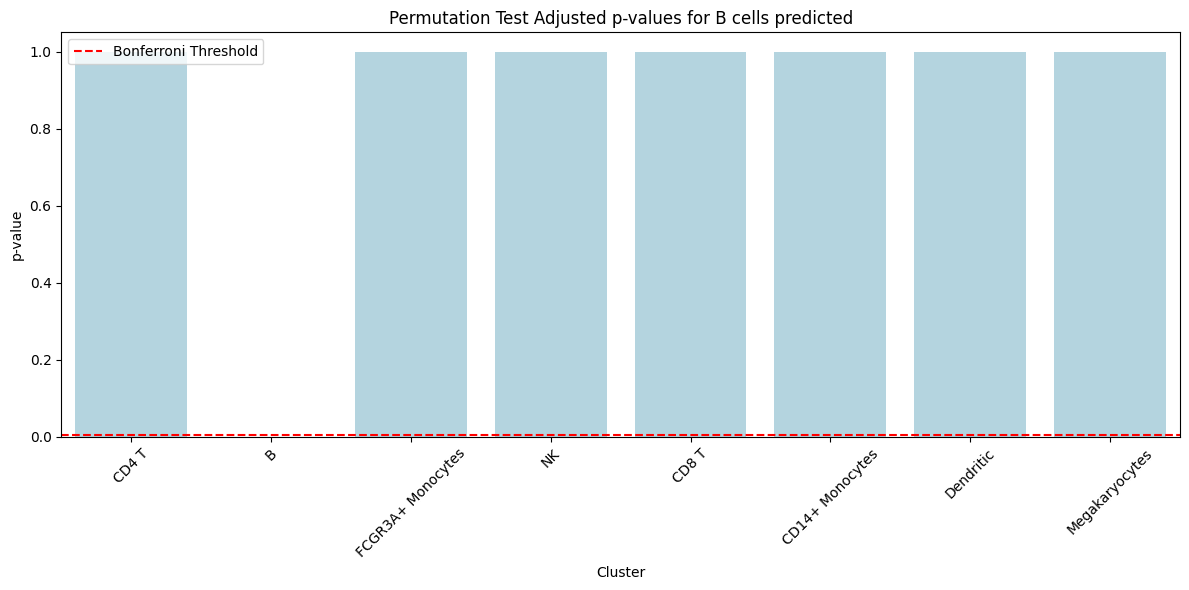

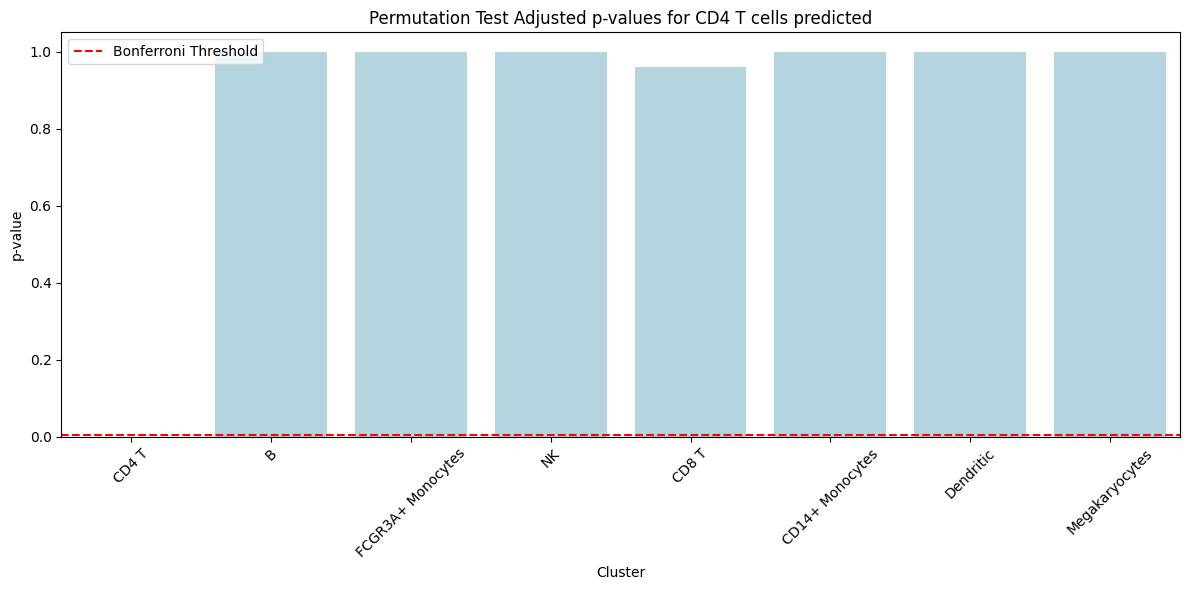

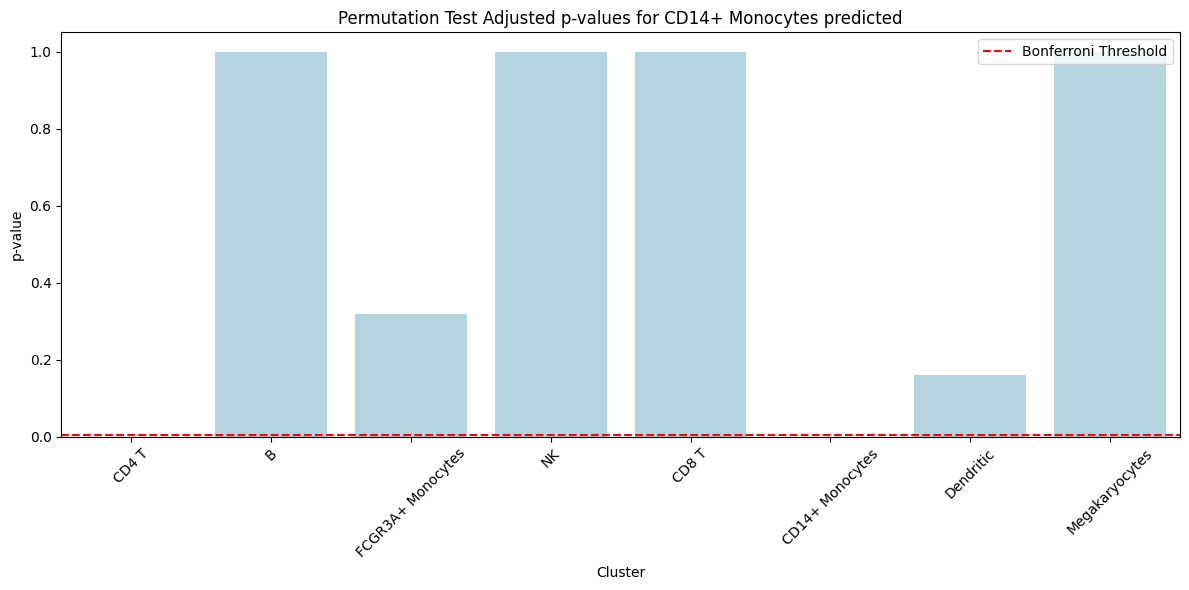

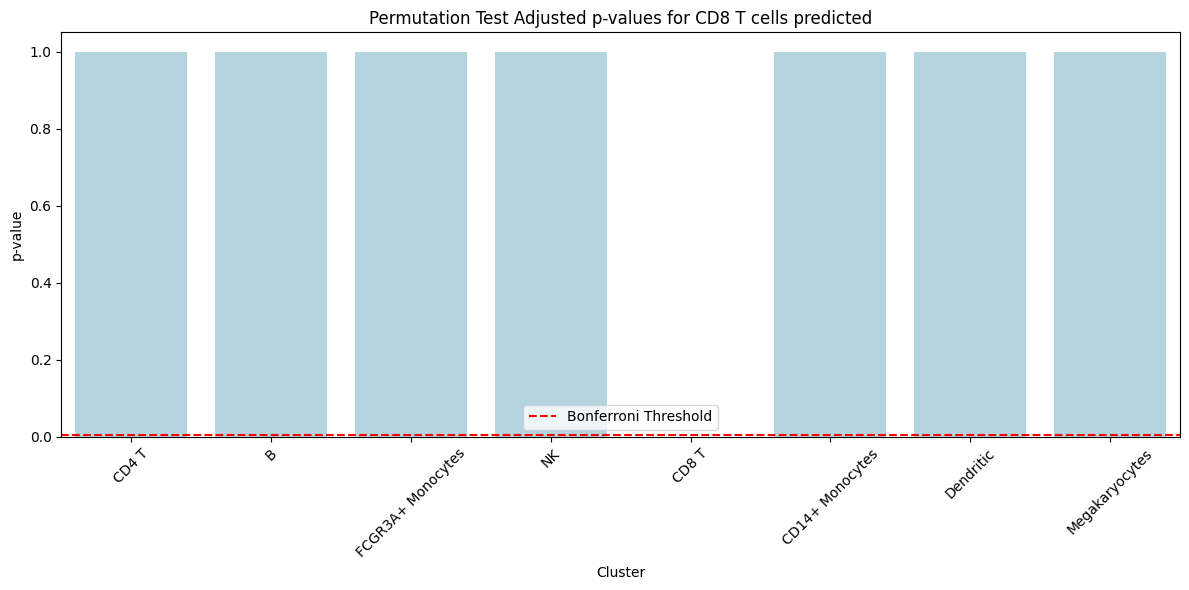

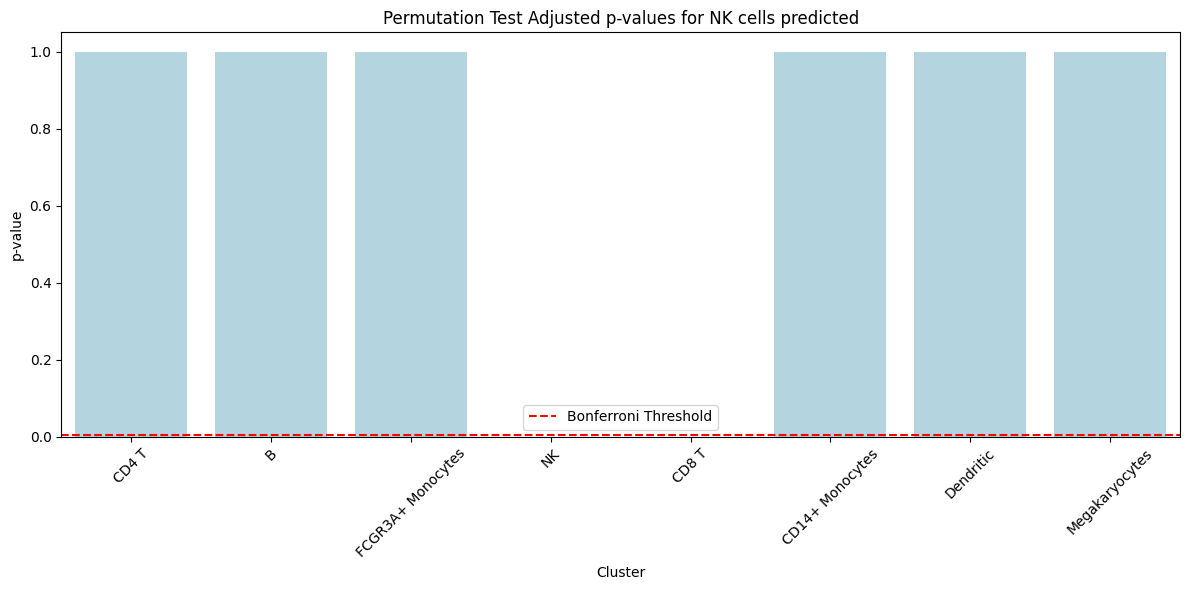

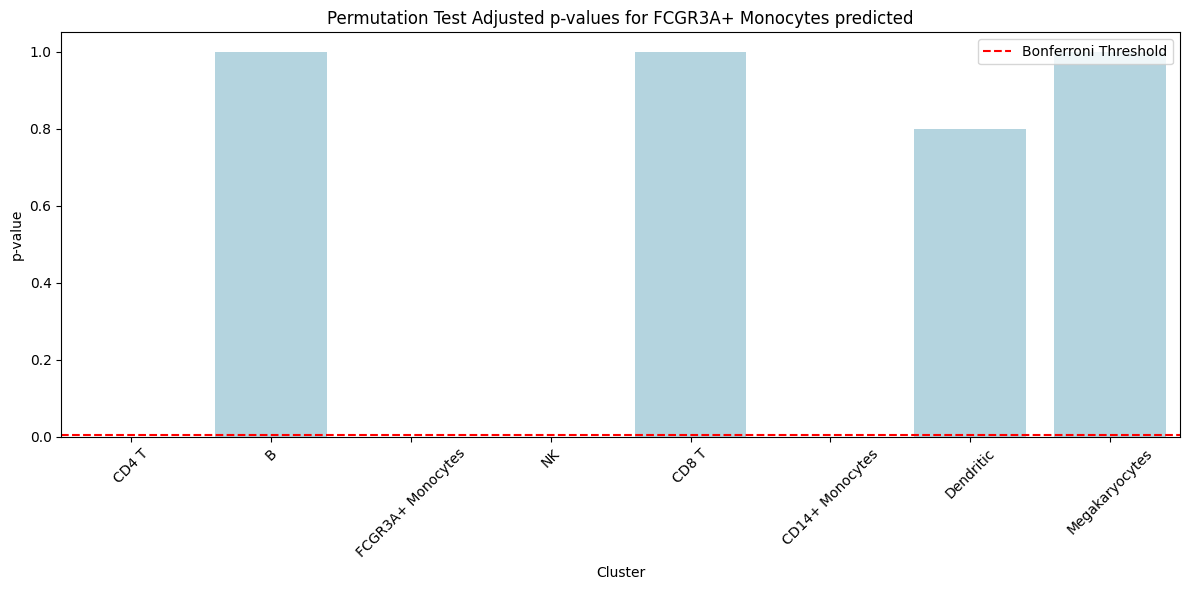

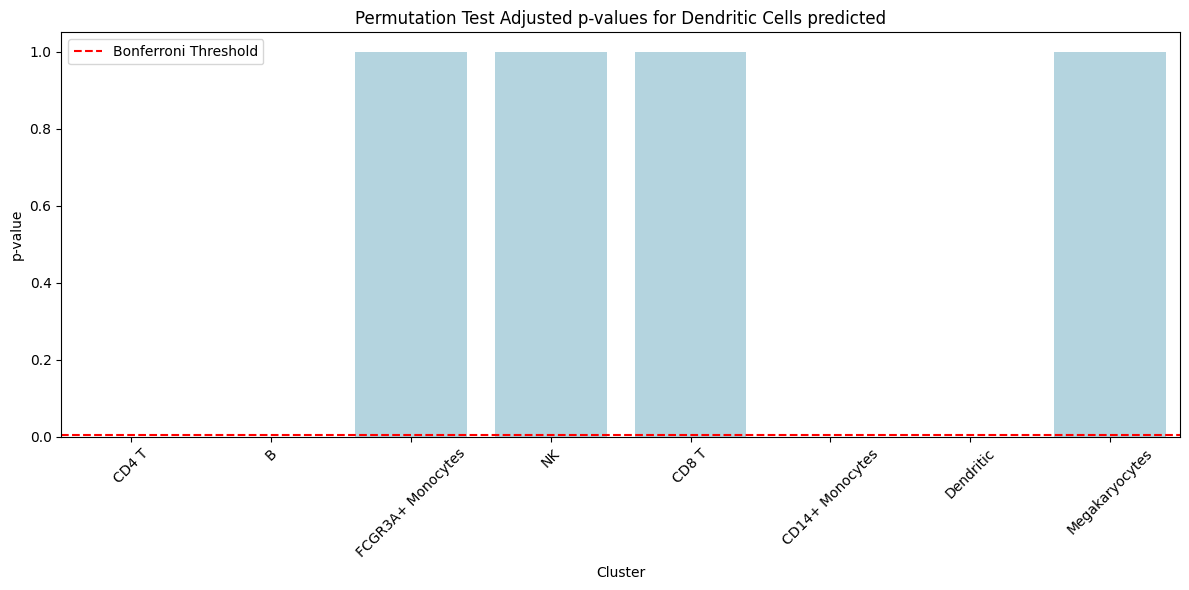

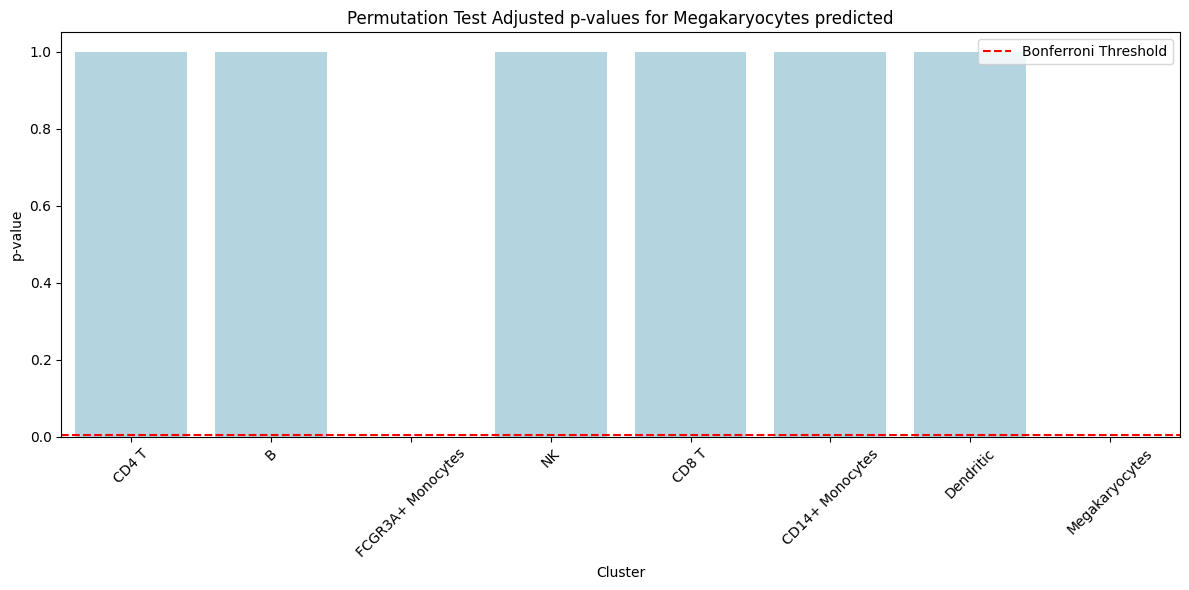

In [33]:
# --- Step 5: Visualization ---
import seaborn as sns
# Create a separate bar plot for each cell type
for cell_type in df_results['Cell_Type_Prediction'].unique():
    df_subset = df_results[df_results['Cell_Type_Prediction'] == cell_type]
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Target_Cluster', y='Adjusted_p-value', data=df_subset, color='lightblue')
    plt.axhline(y=0.05/10, color='red', linestyle='--', label='Bonferroni Threshold')
    plt.title(f'Permutation Test Adjusted p-values for {cell_type}')
    plt.ylabel('p-value')
    plt.xlabel('Cluster')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
import pandas as pd

def plot_ot_sinkhorn_distances(
    df,
    x='Cell_Type_Prediction',
    y='Observed_OT_Distance',
    hue='Target_Cluster',
    figsize=(20, 8),
    title='OT Sinkhorn Distances per Cluster and Cell Type\nwith Bonferroni-Adjusted p-values',
    palette='tab20',
    save_path=None
):
    """
    Plots a bar chart of OT Sinkhorn distances grouped by predicted cell types and true clusters.

    Parameters:
    - df: pandas DataFrame containing the data
    - x: column name for x-axis (default: 'Cell_Type_Prediction')
    - y: column name for y-axis (default: 'Observed_OT_Distance')
    - hue: column name for grouping (default: 'Target_Cluster')
    - figsize: tuple for figure size (default: (20, 8))
    - title: plot title
    - palette: seaborn color palette (default: 'tab20')
    - save_path: if provided, saves the plot to the given file path
    """
    # Sort by OT distance within each cluster (optional for better visuals)
    df_sorted = (
        df.groupby(hue, group_keys=False)
        .apply(lambda x_: x_.sort_values(by=y, ascending=True))
    )

    # Create the plot
    plt.figure(figsize=figsize)
    sns.set(style="whitegrid")

    sns.barplot(
        data=df_sorted,
        x=x,
        y=y,
        hue=hue,
        palette=palette
    )

    plt.legend(title='True Cell Type Annotation', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Predicted Cell Type Annotation', fontsize=12)
    plt.ylabel('Observed OT Sinkhorn Distance', fontsize=12)
    plt.title(title, fontsize=16)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

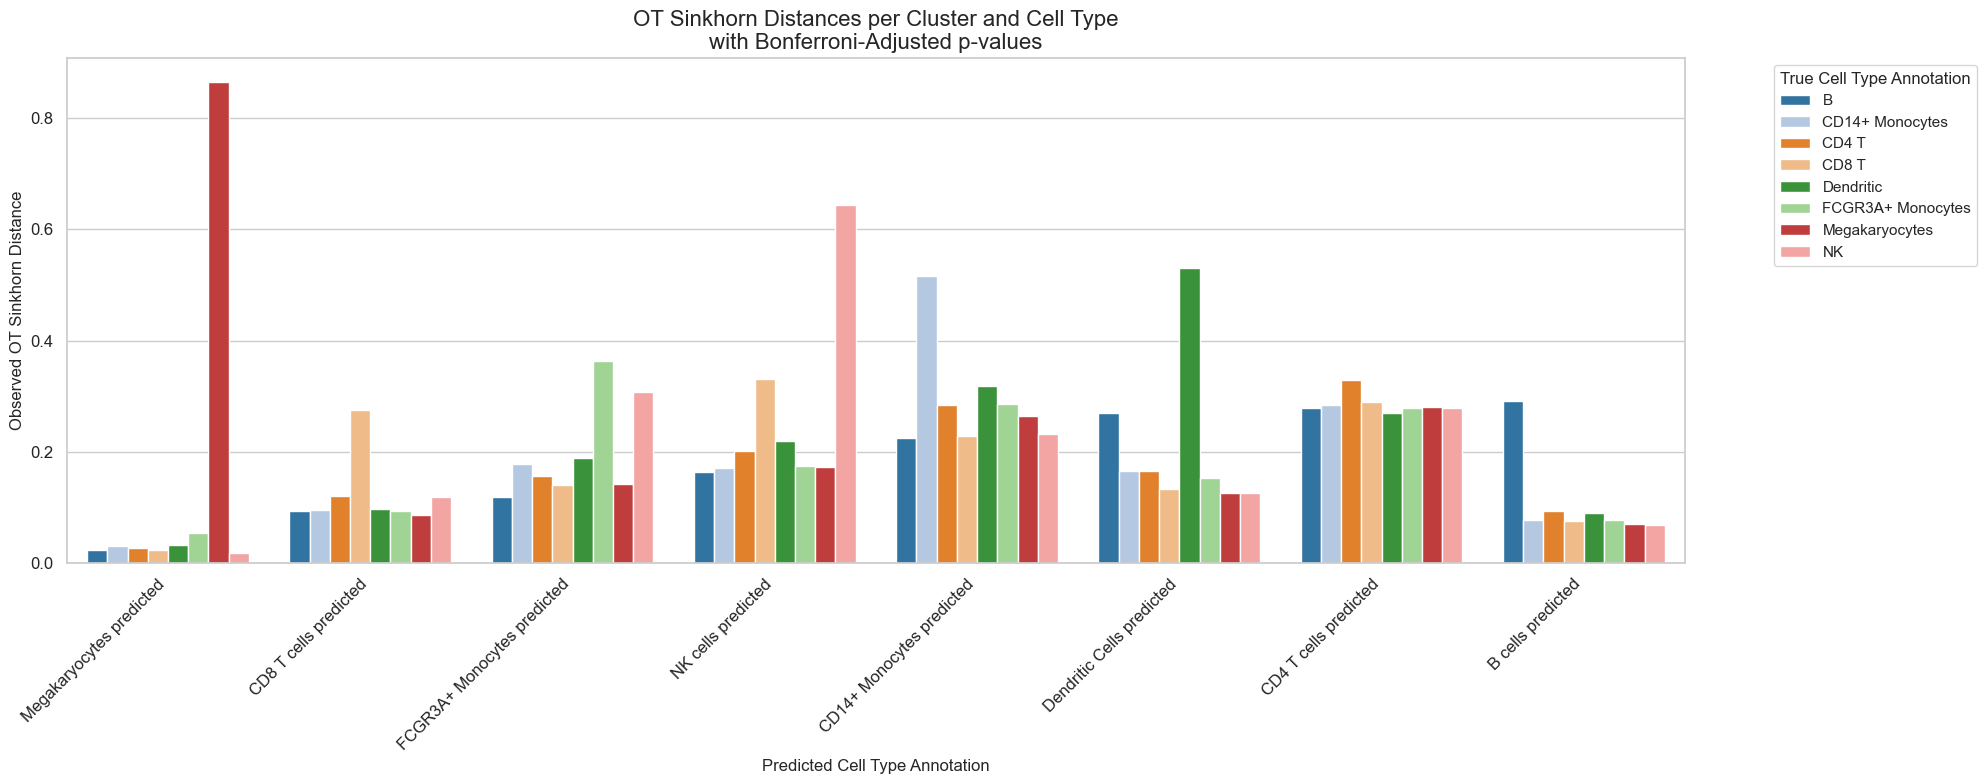

In [41]:
# Assuming df_results is your DataFrame
plot_ot_sinkhorn_distances(df_results)

In [ ]:
# Define the assign_cell_types function as shown above
def assign_cell_types(df, adjusted_pval_col='Adjusted_p-value', pval_threshold=0):
    """
    Assigns cell types to target clusters based on the highest Observed_OT_Distance among significant associations.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the results with columns:
        ['Cell_Type_Prediction', 'Target_Cluster', 'Observed_OT_Distance', 'p-value', 'Adjusted_p-value']
    - adjusted_pval_col (str): Name of the column containing adjusted p-values.
    - pval_threshold (float): Threshold to determine significance (e.g., 0 for p <= 0).

    Returns:
    - cluster_to_celltype (dict): Mapping from Target_Cluster to Cell_Type_Prediction.
    - df_top_clusters (pd.DataFrame): DataFrame containing the top Target_Cluster for each Cell_Type_Prediction.
    """
    # Step 1: Filter for significant associations
    df_sig = df[df[adjusted_pval_col] <= pval_threshold].copy()

    # Ensure 'Observed_OT_Distance' is numeric
    df_sig['Observed_OT_Distance'] = pd.to_numeric(df_sig['Observed_OT_Distance'], errors='coerce')

    # Drop rows with missing Observed_OT_Distance
    df_sig = df_sig.dropna(subset=['Observed_OT_Distance'])

    # Step 2: For each Cell_Type_Prediction, find the Target_Cluster with the highest Observed_OT_Distance
    df_top_clusters = df_sig.loc[df_sig.groupby('Cell_Type_Prediction')['Observed_OT_Distance'].idxmax()].reset_index(drop=True)

    # Step 3: Create a mapping from Target_Cluster to Cell_Type_Prediction
    cluster_to_celltype = pd.Series(
        df_top_clusters.Cell_Type_Prediction.values,
        index=df_top_clusters.Target_Cluster
    ).to_dict()

    return cluster_to_celltype, df_top_clusters

# Use the function with your DataFrame
cluster_to_celltype, df_top_clusters = assign_cell_types(df_results)

# Display the mapping
print("Mapping of Target Clusters to Cell Types:")
for cluster, celltype in cluster_to_celltype.items():
    print(f"{cluster}: {celltype}")

Mapping of Target Clusters to Cell Types:
B: B cells predicted
CD14+ Monocytes: CD14+ Monocytes predicted
CD4 T: CD4 T cells predicted
CD8 T: CD8 T cells predicted
Dendritic: Dendritic Cells predicted
FCGR3A+ Monocytes: FCGR3A+ Monocytes predicted
Megakaryocytes: Megakaryocytes predicted
NK: NK cells predicted


In [37]:
# Assign the annotations to adata.obs
adata.obs['Cell_Type_Annotation'] = adata.obs['leiden'].map(cluster_to_celltype)

# Verify the assignment
print(adata.obs[['leiden', 'Cell_Type_Annotation']].head())

                             leiden         Cell_Type_Annotation
index                                                           
AAACATACAACCAC-1              CD4 T        CD4 T cells predicted
AAACATTGAGCTAC-1                  B            B cells predicted
AAACATTGATCAGC-1              CD4 T        CD4 T cells predicted
AAACCGTGCTTCCG-1  FCGR3A+ Monocytes  FCGR3A+ Monocytes predicted
AAACCGTGTATGCG-1                 NK           NK cells predicted


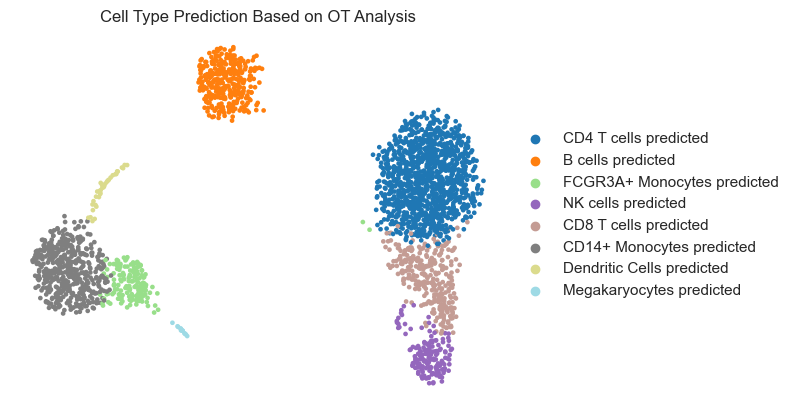

In [ ]:
# Plot UMAP with Cell_Type_Annotation
sc.pl.umap(
    adata, 
    color=['Cell_Type_Annotation'], 
    title='Cell Type Prediction Based on OT Analysis',   
    palette='tab20',
    frameon=False                 # Remove frame for aesthetics
)

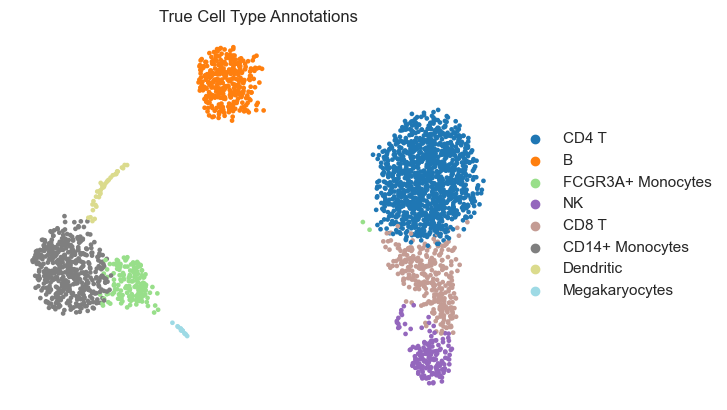

In [39]:
# Plot UMAP with Cell_Type_Annotation
sc.pl.umap(
    adata, 
    color=['leiden'], 
    title='True Cell Type Annotations',   
    palette='tab20',
    frameon=False                 # Remove frame for aesthetics
)